##### Import modules and set up file locations

In [1]:
import Sequence_Analysis_Routines as sar
import random
from joblib import Parallel, delayed
from scipy import optimize as opt
from tqdm import tqdm
import matplotlib.pyplot as plt
import logomaker as lm
import math
import pandas as pd
import subprocess
import numpy as np
import ete3;
import pickle

C:\Users\nicho\Anaconda3\envs\Projects\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\nicho\Anaconda3\envs\Projects\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
project_dir = 'D:/Project_Data/Project_3'
sonic_paranoid_run_name = 'Run_Without_Outgroup'
outgroup_sonic_paranoid_run_name = 'Run_With_Outgroup'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets_Close_Species/'
output_dir = project_dir + '/Output/Close_Species'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
outgroup_protein_fasta_output_loc = output_dir + '/Protein_Sequences_With_Outgroup'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups/flat.ortholog_groups.tsv'
outgroup_ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups/flat.ortholog_groups.tsv'
#single_copy_ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups/single-copy_groups.tsv'
#outgroup_single_copy_ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups/single-copy_groups.tsv'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'
outgroup_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup'
outgroup_concatenated_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup_Concatenated'

In [3]:
num_cores = 16
offset = 50
tb_species = 'GCF_000195955.2'
outgroup_species = 'GCF_000696675.2'

##### Determine genomes in ortholog family, generate protein files and run Sonic Paranoid (both with and without outgroup - outgroup needed for tree building)

In [4]:
genome_ids_with_outgroup = sar.list_dirs(genome_datasets_dir)
genome_ids = sar.list_dirs(genome_datasets_dir)
genome_ids.remove(outgroup_species)
num_ids = len(genome_ids)
num_ids_with_outgroup = len(genome_ids_with_outgroup)

In [5]:
for folder in sar.tqdm(genome_ids):
    sar.generate_protein_file(genome_datasets_dir + '/' + folder + '/genomic.gbff', protein_fasta_output_loc + '/' + folder + '.faa')
for folder in sar.tqdm(genome_ids_with_outgroup):
    sar.generate_protein_file(genome_datasets_dir + '/' + folder + '/genomic.gbff', outgroup_protein_fasta_output_loc + '/' + folder + '.faa')

100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


In [ ]:
#sar.run_sonic_paranoid(protein_fasta_output_loc, sonic_paranoid_output_loc, sonic_paranoid_run_name)
#sar.run_sonic_paranoid(outgroup_protein_fasta_output_loc, sonic_paranoid_output_loc, outgroup_sonic_paranoid_run_name)

##### Generate ortholog object and object containing sequence information for each ortholog group / species

In [6]:
orthologs = sar.Ortholog_Grouping(ortholog_file_ref)
outgroup_orthologs = sar.Ortholog_Grouping(outgroup_ortholog_file_ref)

100%|██████████| 84312/84312 [00:03<00:00, 22698.29it/s]


In [7]:
seq_data = sar.Ortholog_Sequence_Dataset(orthologs, genome_datasets_dir, genome_ids, offset, tb_species) 
outgroup_seq_data = sar.Ortholog_Sequence_Dataset(outgroup_orthologs, genome_datasets_dir, genome_ids_with_outgroup, offset, tb_species) 
print(outgroup_seq_data.species_info())

100%|██████████| 12/12 [00:27<00:00,  2.26s/it]

                                    name          species
0      Mycobacterium kansasii ATCC 12478  GCF_000157895.3
0       Mycobacterium tuberculosis H37Rv  GCF_000195955.2
0    Mycobacterium haemophilum DSM 44634  GCF_000340435.2
0          Rhodococcus erythropolis R138  GCF_000696675.2
0         Mycolicibacterium vaccae 95051  GCF_001655245.1
0           Mycobacterium intracellulare  GCF_002285675.1
0                   Mycobacterium cookii  GCF_010727945.1
0             Mycobacterium shinjukuense  GCF_010730055.1
0                    Mycobacterium lacus  GCF_010731535.1
0                  Mycobacterium marinum  GCF_016745295.1
0  Mycolicibacterium hassiacum DSM 44199  GCF_900603025.1
0    Mycolicibacterium smegmatis MC2 155      NC_008596.1


##### Perform CDS and non-CDS alignments for each full ortholog group and save to folders

In [8]:
min_species = num_ids
min_species_with_outgroup = num_ids_with_outgroup
core_numbers = list(range(1, num_cores+1))
groups = random.sample(orthologs.full_single_copy_ortholog_groups, len(orthologs.full_single_copy_ortholog_groups))  #Permutation ensures even distribution of processing speeds
outgroup_groups = random.sample(outgroup_orthologs.full_single_copy_ortholog_groups, len(orthologs.full_single_copy_ortholog_groups))  #Permutation ensures even distribution of processing speeds
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(outgroup_groups, num_cores, core_number, outgroup_seq_data.sequence_data, 'cds_length', 'cds_seq', outgroup_cds_output_dir+'/', min_species_with_outgroup) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'cds_length', 'cds_seq', cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'non_cds_offset_length', 'non_cds_offset_seq', non_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'upstream_non_cds_offset_length', 'upstream_non_cds_offset_seq', upstream_non_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))

100%|██████████| 16/16 [00:00<00:00, 347.79it/s]


##### Run IQTree on concatenated CDS alignments to generate tree

In [ ]:
alignment_names = sar.list_files(outgroup_cds_output_dir)
sar.concatenate_fasta(outgroup_cds_output_dir, alignment_names, outgroup_concatenated_cds_output_dir + '/concatenated_cds.fasta')
#subprocess.run('cd \\users\\nicho\\IQTree & bin\\iqtree2 -s ' + outgroup_concatenated_cds_output_dir + '/concatenated_cds.fasta' + ' --prefix '+ output_dir + '/Trees/Concatenated_JC_Tree -m JC -B 1000 -T AUTO -o ' + outgroup_species, shell=True)

##### Calibrate Phylo HMM

In [9]:
num_symbols = 4
num_states = 3
minimum_fit_length = 10

In [10]:
tree = ete3.Tree(output_dir + '/Trees/Concatenated_JC_Tree.treefile')
outgroup = tree.search_nodes(name= outgroup_species)[0]
outgroup.delete()

In [11]:
alignment_ids = sar.list_files(non_cds_output_dir+'/')
alignment_ids = [int(i.split('.')[0]) for i in alignment_ids]
alignment_dict = {}
for group_id in tqdm(alignment_ids):
        alignment = sar.Alignment(non_cds_output_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
        alignment.modify_sequence(1, False, False)
        alignment_dict[group_id] = alignment

# Base sequence names on order in final alignment 
sequence_names = alignment.sequence_names
master_species_index = alignment.master_species_index
sequence_name_dict = {}
for n in sequence_names:
    sequence_name_dict[n] = sequence_names.index(n)

100%|██████████| 1327/1327 [00:00<00:00, 1535.81it/s]


In [ ]:
def parallel_fit_hmm (params):
    core_numbers = range(1, num_cores+1)
    a = Parallel(n_jobs=-1)(delayed(sar.fit_phylo_hmm)(tree, num_symbols, num_states, params, alignment_ids, alignment_dict, num_cores, core_number, offset, minimum_fit_length) for core_number in core_numbers)
    print(params, sum(a))
    return sum(a)  

In [ ]:
#sar.fit_phylo_hmm(tree, num_symbols, num_states, [0.97, 0.97, 8,0.2], alignment_ids, alignment_dict, 16, 1, offset, minimum_fit_length)

In [ ]:
#res = opt.minimize(parallel_fit_hmm, (0.97, 0.97, 8,0.2), method = 'Nelder-Mead', bounds = ((0.001,0.999),(0.001,0.999),(0.001,10),(0.001,10)))

##### Fit Cons HMM

In [ ]:
def parallel_fit_cons_hmm (params):
    core_numbers = range(1, num_cores+1)
    a = Parallel(n_jobs=-1)(delayed(sar.fit_cons_hmm)(num_symbols, num_states, params, alignment_ids, alignment_dict, num_cores, core_number, offset, minimum_fit_length, sequence_name_dict, master_species_index) for core_number in core_numbers)
    print(params, sum(a))
    return sum(a)  

In [ ]:
params = [0.9, 0.5, 0.9, 0.5, 0.9, 0.5, 0.9,0.2,0.2]
bound_tuple = [(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999)]

In [ ]:
#res = opt.minimize(parallel_fit_cons_hmm, params, method = 'Nelder-Mead', bounds = bound_tuple)

In [12]:
#fitted_parameters = [0.96731688, 0.92605748, 8.4243919,  1.26477696]  #Forward three state phylo
fitted_parameters = [0.95369268, 0.60983828, 0.83517505, 0.22289673, 0.79386769, 0.1580283, 0.89283101, 0.56297521, 0.14392359] 
#fitted_parameters = res.x

##### Remove portions of alignment gapped for TB and prepare data to plot entropies and logos and estimate conserved regions based on HMM calibrated to all non-CDS (see separate calibration notebook)

In [13]:
utr_upstream_dict = {}
utrs = pd.read_csv(project_dir + '/Datasets/Data_From_Publications/strict_3UTRs.csv', header=0)
for i, r in tqdm(utrs.iterrows(), total=utrs.shape[0]):
    utr_upstream_dict[r['upstream']] = [r['utr'], r['start']-1, r['stop']-1, r['strand'], r['downstream']]

100%|██████████| 586/586 [00:00<00:00, 25479.84it/s]


In [67]:
for downstream in [True, False]:
    if downstream == True:
        alignment_dir = non_cds_output_dir
    else:
        alignment_dir = upstream_non_cds_output_dir
    alignment_info_dict = {}
    file_ids = sar.list_files(alignment_dir+'/')
    ids = [int(i.split('.')[0]) for i in file_ids]

    for group_id in tqdm(ids):
        alignment = sar.Alignment(alignment_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
        alignment.modify_sequence(1,False,False)
        alignment.calculate_entropies(mvave_len = 10)
        alignment_list =  alignment.modified_sequence_list
        alignment_names = alignment.sequence_names
        alignment_2 = sar.Alignment(alignment_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
        alignment_2.modify_sequence(1, False, False)
        alignment_3 = sar.Alignment(alignment_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
        alignment_3.modify_sequence(1, False, True)

        sequence_names = alignment.sequence_names
        master_species_index = alignment.master_species_index
        sequence_name_dict = {}
        for n in sequence_names:
            sequence_name_dict[n] = sequence_names.index(n)
        cds_end_pos = offset - 1
        non_cds_end_pos = alignment.modified_sequence_length - offset

        if downstream == True:
            non_cds_offset_start = seq_data.master_species_info(group_id, 'non_cds_offset_start')
            non_cds_offset_end = seq_data.master_species_info(group_id, 'non_cds_offset_end')
        else:
            non_cds_offset_start = seq_data.master_species_info(group_id, 'upstream_non_cds_offset_start')
            non_cds_offset_end = seq_data.master_species_info(group_id, 'upstream_non_cds_offset_end')

        if downstream == True:
            locus_tag = seq_data.master_species_info(group_id, 'locus_tag')
            locus_strand = seq_data.master_species_info(group_id, 'strand')
            if locus_strand == 1:
                locus_tag_2 = seq_data.master_species_info(group_id, 'next_locus_tag')
                locus_strand_2 = seq_data.master_species_info(group_id, 'next_strand')
            else:
                locus_tag_2 = seq_data.master_species_info(group_id, 'previous_locus_tag')
                locus_strand_2 = seq_data.master_species_info(group_id, 'prev_strand')
        else:
            locus_tag_2 = seq_data.master_species_info(group_id, 'locus_tag')
            locus_strand_2 = seq_data.master_species_info(group_id, 'strand')
            if locus_strand_2 == 1:
                locus_tag = seq_data.master_species_info(group_id, 'previous_locus_tag')
                locus_strand = seq_data.master_species_info(group_id, 'prev_strand')
            else:
                locus_tag = seq_data.master_species_info(group_id, 'next_locus_tag')
                locus_strand = seq_data.master_species_info(group_id, 'next_strand')

        utr_start_pos = 0
        utr_end_pos = 0

        if locus_tag in utr_upstream_dict:
            utr_data = utr_upstream_dict[locus_tag]
            if cds_strand == 1:
                utr_start_pos = utr_data[1] - non_cds_offset_start
                utr_end_pos = utr_data[2] - non_cds_offset_start
            else:
                utr_start_pos = non_cds_offset_end - utr_data[2]
                utr_end_pos = non_cds_offset_end- utr_data[1]

        initial_state_probabilities = [1.0/num_states]*num_states
        a = fitted_parameters[0]; b = (1-fitted_parameters[0])*(fitted_parameters[1]); c = 1 - b - a
        e = fitted_parameters[2]; d = (1-fitted_parameters[2])*(fitted_parameters[3]); f = 1 - d - e
        i = fitted_parameters[4]; g = (1-fitted_parameters[4])*(fitted_parameters[5]); h = 1 - i - g
        transition_probabilities = np.array([[a,b,c],[d,e,f],[g,h,i]])
        #observation_probabilities = sar.mutation_probs(fitted_parameters[2:len(fitted_parameters)], alignment_list, alignment_names, tree, num_symbols)
        observation_probabilities = sar.cons_mutation_probs([fitted_parameters[6],fitted_parameters[7],fitted_parameters[8]], alignment_list, alignment_names, num_symbols, sequence_name_dict, master_species_index)
        hmm = sar.HMM(initial_state_probabilities, transition_probabilities, observation_probabilities)
        hmm.viterbi(); hmm.forward(); hmm.backward()      
        alignment_info_dict[group_id] = [alignment, alignment_2, alignment_3, cds_end_pos, non_cds_end_pos, non_cds_offset_start, non_cds_offset_end, 
                                         locus_tag, locus_strand, locus_tag_2, locus_strand_2, utr_start_pos, utr_end_pos, hmm]
    if downstream == True:
        dict_name = 'downstream_conservation_info_dictionary'
    else:
        dict_name = 'upstream_conservation_info_dictionary'
    with open(output_dir + '/' + dict_name + '.pkl', 'wb') as f:
        pickle.dump(alignment_info_dict, f)

100%|██████████| 1337/1337 [00:42<00:00, 31.73it/s]


In [68]:
with open(output_dir + '/upstream_conservation_info_dictionary.pkl', 'rb') as f:
    upstream_conservation_info_dictionary = pickle.load(f)
with open(output_dir + '/downstream_conservation_info_dictionary.pkl', 'rb') as f:
    downstream_conservation_info_dictionary = pickle.load(f)

##### Plot graphics to show sequence and HMM regions

In [69]:
def conservation_plot(group_id, conservation_info_dictionary):
    data = conservation_info_dictionary[group_id]
    alignment = data[0]; alignment_2 = data[1]; alignment_3 = data[2]; cds_end_pos = data[3]; non_cds_end_pos = data[4]; non_cds_offset_start = data[5]; non_cds_offset_end = data[6]; 
    locus_tag = data[7]; cds_strand = data[8]; locus_tag_2 = data[9]; locus_strand_2 = data[10]; utr_start_pos = data[11]; utr_end_pos = data[12]; hmm = data[13]

    counts_df = lm.alignment_to_matrix(sequences = alignment.modified_sequence_list, to_type = 'counts', characters_to_ignore = '-', pseudocount=0)
    background_probs = [0.25, 0.25, 0.25, 0.25]
    for i, r in counts_df.iterrows():
        temp_relent = []
        num_gaps = alignment.num_sequences
        for k in range(4):
            num_gaps = num_gaps - r.iloc[k]
        for k in range(4):
            ct = r.iloc[k] + num_gaps*background_probs[k]
            if ct == 0:
                temp_relent.append(0)
            else:
                temp_relent.append((ct /alignment.num_sequences) * math.log((ct /alignment.num_sequences)/background_probs[k],2))
        for k in range(4):
            r.iloc[k] = temp_relent[k]

    y = -1        
    seqlogo = lm.Logo(counts_df, figsize = [25,1])
    seqlogo.ax.plot([0, cds_end_pos], [y,y], color='skyblue', linewidth=10, solid_capstyle='butt')
    for i in alignment_2.master_species_modified_sequence_insertions:
        seqlogo.ax.plot([i[0], i[0]+1], [y-2,y-2], color='red', linewidth=3*i[1], solid_capstyle='butt')
    seqlogo.ax.plot([non_cds_end_pos, alignment.modified_sequence_length], [y,y], color='skyblue', linewidth=10, solid_capstyle='butt')
    seqlogo.ax.plot([utr_start_pos, utr_end_pos],[y-0.5, y-0.5], color='mediumslateblue', linewidth=10, solid_capstyle='butt')
    for i, state in enumerate(hmm.viterbi_path):
        if state in [0]:
            seqlogo.highlight_position_range(pmin=i, pmax=i, color='rosybrown')
    seqlogo.ax.text(0,4.2*y,locus_tag + ' ('+str(cds_strand)+')',fontsize=12)
    seqlogo.ax.text(alignment.modified_sequence_length - offset/2,4.2*y,locus_tag_2+ ' ('+str(locus_strand_2)+')',fontsize=12)
    seqlogo.ax.text(0, 4.5*y,int(non_cds_offset_start), verticalalignment='top', horizontalalignment='left')
    seqlogo.style_spines(visible=False)
    seqlogo.style_spines(spines=['left'], visible=True, bounds=[0, 2])
    seqlogo.ax.set_xticks([])
    seqlogo.ax.set_yticks([0,2])
    seqlogo.ax.set_ylim([-4, 2])
    seqlogo.ax.axhline(y, color = 'k', linewidth = 1)
    seqlogo;

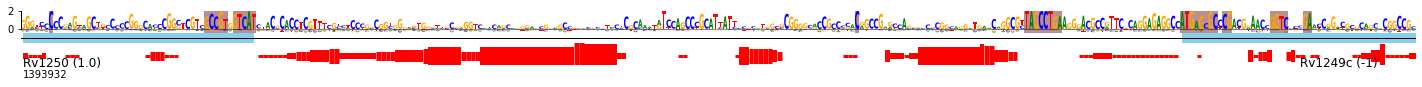

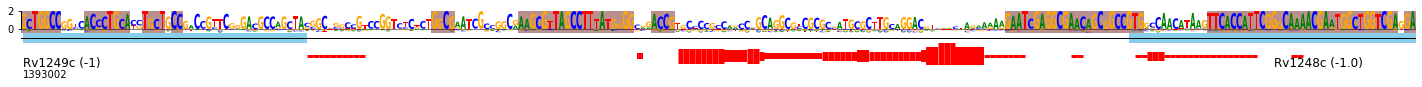

In [78]:
group_id = 772 #752   756   758    772   791 953  786  845 805 shows non insertions
    #975 Shine Dalgarno  1048
conservation_plot(group_id, upstream_conservation_info_dictionary)
conservation_plot(group_id, downstream_conservation_info_dictionary)

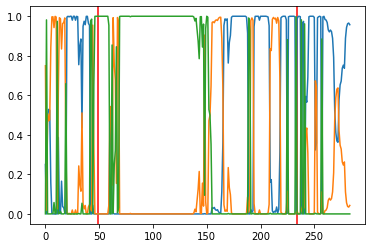

In [47]:
#plt.plot(alignment.relative_entropy);
#plt.plot(alignment.mvave_relative_entropy);
plt.axvline(x=cds_end_pos, ymin=0, ymax=2, color='r');
plt.axvline(x=non_cds_end_pos, ymin=0, ymax=2, color='r');
for state in range(3):
    c = hmm.forward_probabilities[state] + hmm.backward_probabilities[state]
    d = [math.exp(x - hmm.forward_ll) for x in c]
    plt.plot(d);

In [ ]:
temp = seq_data.sequence_data
print(temp[temp['locus_tag'] == 'Rv1249c'])

In [ ]:
file_ids = sar.list_files(non_cds_output_dir+'/')
ids = [int(i.split('.')[0]) for i in file_ids]
for id in tqdm(ids):
    if id in conservation_info_dict:
        temp = conservation_info_dict[id]
        viterbi_path = temp[12].viterbi_path
        viterbi_path_length = len(viterbi_path) 
        conserved_length = sum(viterbi_path[50:viterbi_path_length - 50])
        num_insertions = len(temp[1].master_species_modified_sequence_insertions)
        sequence_length = temp[0].modified_sequence_length
        if sequence_length > 150 and conserved_length > 50:
            print (id, sequence_length, conserved_length, conserved_length/sequence_length, num_insertions)

In [71]:
temp= seq_data.sequence_data

In [75]:
temp[temp['group_id'] == 2049]

,group_id,species,protein_id,num_protein_ids,name,type,locus_tag,previous_locus_tag,next_locus_tag,bp_restrict,...,cds_length,non_cds_length,upstream_non_cds_length,ss_non_cds_length,non_cds_offset_length,non_cds_offset_start,non_cds_offset_end,upstream_non_cds_offset_length,upstream_non_cds_offset_start,upstream_non_cds_offset_end
1825,2049,GCF_000157895.3,WP_023366241.1,1.0,Mycobacterium kansasii ATCC 12478,CDS,MKAN_RS06095,MKAN_RS06090,MKAN_RS06100,0.0,...,486,0.0,227.0,0.0,92.0,1426664.0,1426756.0,327.0,1427142.0,1427469.0
1851,2049,GCF_000195955.2,NP_215819.1,1.0,Mycobacterium tuberculosis H37Rv,CDS,Rv1303,Rv1302,Rv1304,0.0,...,486,0.0,256.0,0.0,92.0,1460201.0,1460293.0,356.0,1459459.0,1459815.0
1835,2049,GCF_000340435.2,WP_047315847.1,1.0,Mycobacterium haemophilum DSM 44634,CDS,B586_RS14150,B586_RS14145,B586_RS14155,0.0,...,456,0.0,249.0,0.0,92.0,3021058.0,3021150.0,349.0,3021506.0,3021855.0
1780,2049,GCF_001655245.1,WP_003931024.1,1.0,Mycolicibacterium vaccae 95051,CDS,MYVA_RS20225,MYVA_RS20220,MYVA_RS20230,0.0,...,447,48.0,279.0,48.0,148.0,4319991.0,4320139.0,379.0,4320486.0,4320865.0
1786,2049,GCF_002285675.1,WP_036458460.1,1.0,Mycobacterium intracellulare,CDS,CKJ67_RS07890,CKJ67_RS07885,CKJ67_RS07895,0.0,...,495,0.0,216.0,0.0,92.0,1601660.0,1601752.0,316.0,1600949.0,1601265.0
1806,2049,GCF_010727945.1,WP_163775982.1,1.0,Mycobacterium cookii,CDS,G6N27_RS08735,G6N27_RS08730,G6N27_RS08740,0.0,...,450,0.0,224.0,0.0,92.0,1856532.0,1856624.0,324.0,1856974.0,1857298.0
1859,2049,GCF_010730055.1,WP_083047753.1,1.0,Mycobacterium shinjukuense,CDS,G6N20_RS02580,G6N20_RS02575,G6N20_RS02585,0.0,...,507,0.0,250.0,0.0,92.0,574584.0,574676.0,350.0,573827.0,574177.0
1857,2049,GCF_010731535.1,WP_085158678.1,1.0,Mycobacterium lacus,CDS,G6N24_RS04765,G6N24_RS04760,G6N24_RS04770,0.0,...,486,0.0,204.0,0.0,92.0,1016213.0,1016305.0,304.0,1015523.0,1015827.0
1807,2049,GCF_016745295.1,WP_012395676.1,1.0,Mycobacterium marinum,CDS,HXW97_RS25825,HXW97_RS25820,HXW97_RS25830,0.0,...,501,0.0,250.0,0.0,92.0,6193076.0,6193168.0,350.0,6193569.0,6193919.0
1828,2049,GCF_900603025.1,WP_005629146.1,1.0,Mycolicibacterium hassiacum DSM 44199,CDS,MHAS_RS13495,MHAS_RS13490,MHAS_RS13500,0.0,...,468,0.0,242.0,0.0,96.0,2878356.0,2878452.0,342.0,2878820.0,2879162.0
